This is a short overview of the order path prediction capabilities that we have.

In [18]:
import os
import sys

import pandas as pd
import plotly.express as px
import numpy as np
import random
import matplotlib.pyplot as plt
from ds_service.predict_location import predict_future_location

print(os.getcwd())
##
# Set data science variables
ship_trac_path =  "./data/gis_opex_international_shiptrac.csv"
international_raw_ = "./data/gis_opex_international_raw.csv"
ship_trac = pd.read_csv(ship_trac_path, sep=';')
international_raw = pd.read_csv(international_raw_, sep=';')
ship_trac["date"] = pd.to_datetime(ship_trac["date"])
ship_trac.sort_values(by="date", ascending = True, inplace=True)
international_raw["datum_abgang"] = pd.to_datetime(international_raw["datum_abgang"])
international_raw.sort_values(by="datum_abgang", ascending = True, inplace=True)
ship_trac

/home/aparker/Documents/HackZurich/backup/data_science


,date,longitude,latitude,imo_number,course,speed,name,destination,eta
78,2020-12-31 01:07:00,48.28738,12.97589,9467251,256.0,18.3,CSCL VENUS,SUEZ CANAL,03.01.2021 13:00
72,2020-12-31 02:24:00,76.97161,6.79023,9780471,287.0,21.8,MUMBAI MAERSK,MYTPP-EGSUZ,06.01.2021 21:00
74,2020-12-31 03:35:00,43.03851,13.25825,9469560,319.0,17.4,MSC TERESA,EGSUZ,02.01.2021 11:00
77,2020-12-31 04:36:00,2.51231,37.15013,9708473,259.0,11.8,YM WREATH,NL RTM,04.01.2021 12:00
79,2020-12-31 04:42:00,40.64130,17.31714,9755933,329.0,19.6,MSC DIANA,SUEZ ANCHORAGE,02.01.2021 20:30
...,...,...,...,...,...,...,...,...,...
169154,2022-12-08 23:59:00,114.11709,22.33337,9647473,147.8,0.0,MSC VENICE,HK HKG,12.08.2022 11:00
169153,2022-12-08 23:59:00,4.05981,51.98498,9629380,111.4,7.7,TOKYO BAY,NLRTM,12.08.2022 21:00
169152,2022-12-08 23:59:00,2.51841,51.82301,9632002,220.1,8.7,APL SINGAPURA,BEANR,13.08.2022 05:30
169149,2022-12-08 23:59:00,25.41992,33.53022,9757216,285.1,12.1,YM WISDOM,NLRTM,24.08.2022 02:00


We have information on the past routes taken by container ships to their destinations.

In [19]:
ship_trac[ship_trac["imo_number"]==9467251]

,date,longitude,latitude,imo_number,course,speed,name,destination,eta
78,2020-12-31 01:07:00,48.28738,12.97589,9467251,256.0,18.3,CSCL VENUS,SUEZ CANAL,03.01.2021 13:00
130,2020-12-31 13:49:00,44.46358,12.15867,9467251,293.0,18.1,CSCL VENUS,SUEZ CANAL,03.01.2021 13:00
196,2020-12-31 20:44:00,42.82171,13.43471,9467251,308.0,20.3,CSCL VENUS,SUEZ CANAL,03.01.2021 13:00
252,2020-12-31 23:47:00,42.33441,14.26733,9467251,335.0,18.6,CSCL VENUS,SUEZ CANAL,03.01.2021 13:00
321,2021-01-01 06:39:00,41.29694,16.15548,9467251,331.0,18.5,CSCL VENUS,SUEZ CANAL,03.01.2021 13:00
...,...,...,...,...,...,...,...,...,...
135619,2022-12-04 23:57:00,35.63367,25.50978,9467251,325.8,18.0,CSCL VENUS,EG SZC,13.04.2022 20:00
160567,2022-12-07 06:59:00,9.91149,42.39056,9467251,4.3,17.9,CSCL VENUS,ITGOA,12.07.2022 13:00
160643,2022-12-07 13:59:00,8.80113,44.15310,9467251,336.6,15.5,CSCL VENUS,ITGOA,12.07.2022 13:00
160716,2022-12-07 20:57:00,8.77991,44.41942,9467251,262.3,0.1,CSCL VENUS,ITGOA,12.07.2022 13:00


In [20]:
unique_ship_labels = ship_trac['imo_number']
for imo_nr in unique_ship_labels[0:1]:
    imo_data = ship_trac[ship_trac['imo_number'] == imo_nr]
    fig = px.scatter_geo(imo_data,lat='latitude',lon='longitude')
fig.show()

We currently just use a very simple geographical estimation of the current location of cargo based on their last coordinate location, speed and direction they are headed, under the assumption they do not change course or speed. In general this is quite a good estimator (as can be seen below the median error is approx 0.5nm and measurements are typically 7 hours apart), however there are some extreme outliers. These outliers are slightly correlated to the time difference, but not greatly. It should be noted however, that the most important component of nautical path estimation is still not accounted for in our model: the topology of the ocean. Our estimates can still return locations in land which are of course inaccurate. 

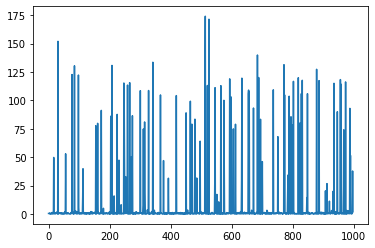

In [21]:
error_list = []
time_diff_list = []
import timedelta
for imo_nr in unique_ship_labels[:1000]:
    imo_data = ship_trac[ship_trac['imo_number'] == imo_nr]
    no_measurements = len(imo_data)
    if no_measurements >3:
        rand = random.randrange(no_measurements-1)
        date, lat, long, speed, course =imo_data.iloc[rand][["date", "latitude", "longitude", "speed", "course"]]
        next_date, next_lat, next_long, next_speed, next_course =imo_data.iloc[rand+1][["date", "latitude", "longitude", "speed", "course"]]
        #print(lat, long)
        #print(next_lat, next_long)
        time_diff = td = timedelta.Timedelta(next_date - date).total.seconds/(60*60)
        pred_lat, pred_long = predict_future_location(lat, long, speed, course, time_diff)
        #print(pred_lat, pred_long)
        error = np.sqrt((next_lat-pred_lat)**2 + (next_long-pred_long)**2)
        error_list.append(error)
        time_diff_list.append(time_diff)
plt.plot(error_list)

In [35]:
print("Median error: (nm)"+str(np.median(error_list)))
print("Median time difference between measurements (h): " + str(np.median(time_diff_list)))
print("Correlation between time difference and error: " + str(np.corrcoef(error_list, time_diff_list)[0,1]))

Median error: (nm)0.48380488050451936
Median time difference between measurements (h): 7.0
Correlation between time difference and error: 0.5161704788586398
